In [3]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径
import sys
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")
from base import    double_control_predict_result,\
                    gaolu_predict_raw,\
                    data_tranform_plot,\
                    get_y_aim_data,\
                    generate_yr,\
                    replace_outliers_with_weighted_diff

from base import MyRNNModel,CustomPredictor_double


In [22]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean.xlsx'
df_sheet_yuansu = pd.read_excel(excel_path, sheet_name='剔除直线输出') 
print(df_sheet_yuansu.info())
print(df_sheet_yuansu.columns)

excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\高频\\1h_mean.xlsx'
df_sheet_params = pd.read_excel(excel_path, sheet_name='1h_mean') 

print(df_sheet_params.info())
print(df_sheet_params.columns)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6632 entries, 0 to 6631
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳h    6632 non-null   int64  
 1   时间戳10m  6632 non-null   int64  
 2   SI      6632 non-null   float64
 3   铁口1温度   6632 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 207.4 KB
None
Index(['时间戳h', '时间戳10m', 'SI', '铁口1温度'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   主参数时间戳2  7377 non-null   int64  
 1   时间戳h     7377 non-null   int64  
 2   富氧流量     7377 non-null   float64
 3   冷风流量     7377 non-null   float64
 4   热风压力     7377 non-null   float64
 5   冷风温度     7377 non-null   float64
 6   热风温度     7377 non-null   float64
 7   鼓风湿度     7377 non-null   float64
 8   设定喷煤量    7377 non-null   float64
dtypes: float64(7), int64(2)
memor

In [25]:
import pandas as pd

# 假设 df 是你的 DataFrame

# 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_yuansu.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")
    # 检查 DataFrame 中是否包含 NaN 值
contains_nan = df_sheet_params.isna().any().any()

if contains_nan:
    print("数据包含 NaN 值")
else:
    print("数据不包含 NaN 值")


数据不包含 NaN 值
数据不包含 NaN 值


In [26]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '冷风温度', '热风温度', '鼓风湿度', '设定喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳h'


C:\Users\haokw\AppData\Local\Temp\ipykernel_27988\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_27988\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_27988\1726023440.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haok

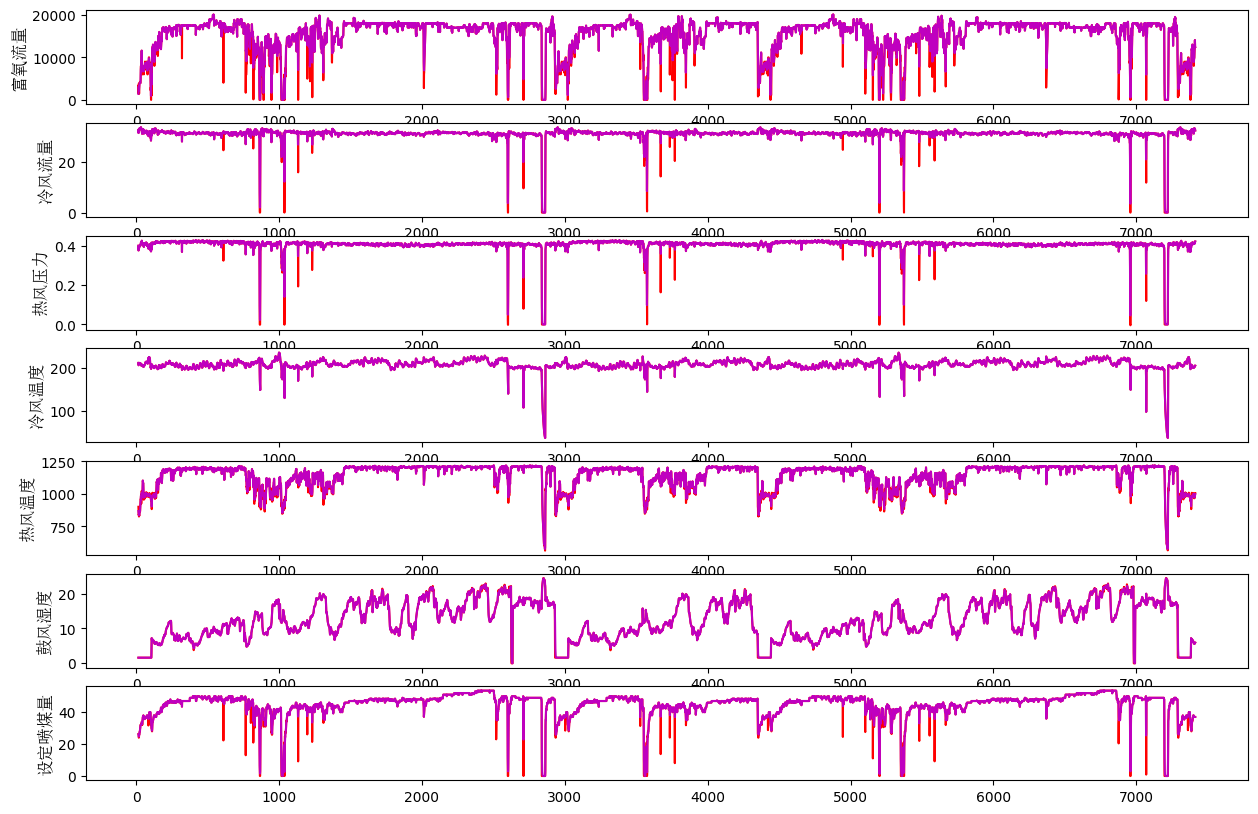

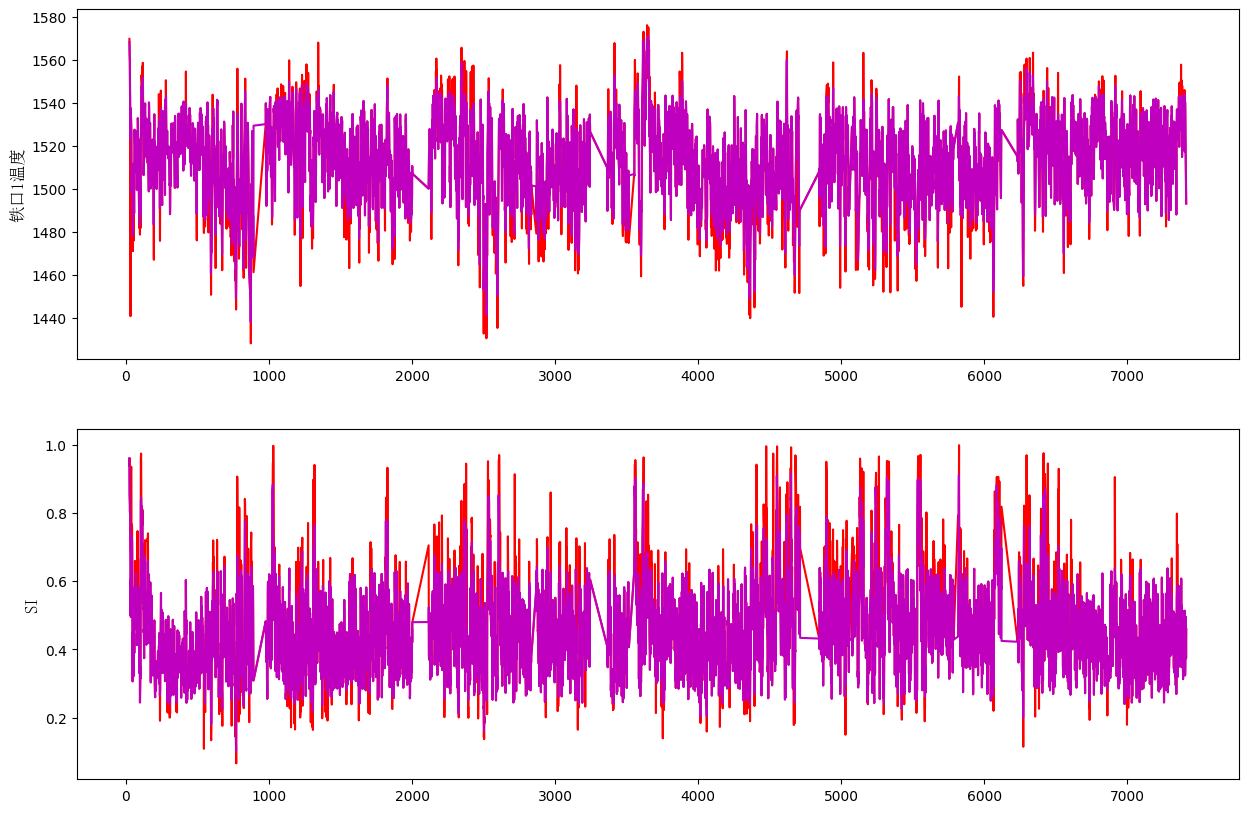

In [27]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_yuansu_process = df_sheet_yuansu.copy()
df_sheet_params_process = df_sheet_params.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_params_process[time_term], df_sheet_params_process[input_term[6]])

replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_yuansu_process[time_term], df_sheet_yuansu_process[output_term[1]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(df_sheet_params_process[time_term].values,df_sheet_params[column].values,df_sheet_params_process[column].values,column)

plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu[column].values,df_sheet_yuansu_process[column].values,column)




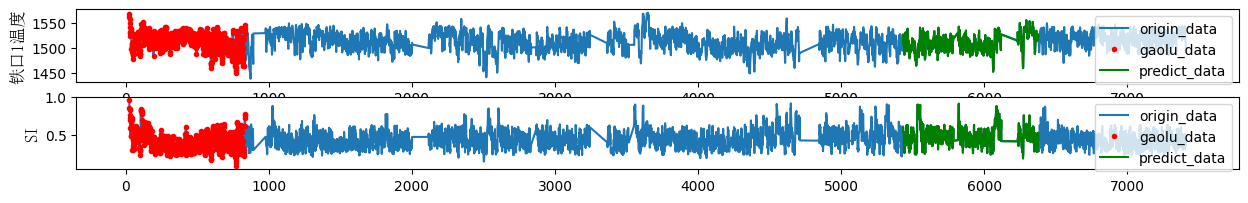

In [56]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r.', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



length1 = 800
start1 = 0
length2 = 800
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_yuansu_process[time_term].values,df_sheet_yuansu_process[column].values,column,index_predict,index_gaolu)


In [39]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_params_process[input_term[0]].values,
    input_term[1]:   df_sheet_params_process[input_term[1]].values,
    input_term[2]:   df_sheet_params_process[input_term[2]].values,
    input_term[3]:   df_sheet_params_process[input_term[3]].values,
    input_term[4]:   df_sheet_params_process[input_term[4]].values,
    input_term[5]:   df_sheet_params_process[input_term[5]].values,
    input_term[6]:   df_sheet_params_process[input_term[6]].values,
    output_term[0]:  df_sheet_yuansu_process[output_term[0]].values,
    output_term[1]:  df_sheet_yuansu_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [40]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_temp = (data3-data1)/(data4-data2)
print('每摄氏度的输出差：',d_temp)



data_point = np.array([0.50]).reshape(-1, 1)
data1 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

data_point = np.array([0.60]).reshape(-1, 1)
data3 = scalers[output_term[1]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
d_yuansu = (data3-data1)/(data4-data2)
print('每0.01浓度的输出差：',(data3-data1))


[-0.06959512]
[1500.]
[0.0811498]
[1510.]
每摄氏度的输出差： [0.01507449]
[-0.07254897]
[0.5]
[0.16062906]
[0.6]
每0.01浓度的输出差： [0.23317803]


In [65]:
isShuffle = True
# isShuffle = False


In [66]:
time_steps = 2


In [80]:
# 组合训练数据--拆分训练、测试集
test_size = 0.15
val_size = test_size
train_size = 1-val_size-test_size
# 定义时间步数和特征数


def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,index_fanwei):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)



    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(3,len(y1_data)):
        if i in index_fanwei:
            # i = 3
            # print(i)
            # print(df_sheet_yuansu[time_term][i])
            yuansu_time = df_sheet_yuansu[time_term][i]
            closest_10 = df_sheet_params[df_sheet_params[time_term] < yuansu_time].nlargest(time_steps, time_term)
            # print(closest_10)
            closest_10 = closest_10.sort_values(by=time_term)
            index = closest_10.index
            # print(index)
            # print(closest_10)
            # print(closest_10.iloc[-1][time_term])
            if closest_10.iloc[-1][time_term] < yuansu_time - time_steps:
                print(i,yuansu_time,'errloss')
            
            else:
                X_sample = X[index, :]
                # print(X_sample)            
                # print(X_sample.shape)
                y_sample = y[i, :]  # 取每个序列的第11个时刻作为输出
                y_last = y[i-1, :].reshape(1,2)
                y_last = np.broadcast_to(y_last, (time_steps, 2))
                X_sample = np.concatenate((X_sample,y_last),axis=1)
                # print(X_sample)

                # print(y_sample)
                X_modified.append(X_sample)
                y_modified.append(y_sample)
                print(i,yuansu_time,index[0],index[-1], end='\r')
                # break

        
    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [68]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_gaolu)



# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]]
u2_data = normalized_data_dict[input_term[1]]
u3_data = normalized_data_dict[input_term[2]]
u4_data = normalized_data_dict[input_term[3]]
u5_data = normalized_data_dict[input_term[4]]
u6_data = normalized_data_dict[input_term[5]]
u7_data = normalized_data_dict[input_term[6]]
y1_data = normalized_data_dict[output_term[0]]
y2_data = normalized_data_dict[output_term[1]]
num_samples = y2_data.shape[0]
print('预测模型数据')
X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            index_fanwei=index_predict)



高炉模型数据
Modified Input Shape: (798, 2, 9)
Modified Output Shape: (798, 2)
训练数量： (558, 2, 9) (558, 2)
验证数量： (120, 2, 9) (120, 2)
测试数量： (120, 2, 9) (120, 2)
预测模型数据
4830 5464 errloss43
4831 5465 errloss
4832 5466 errloss
4833 5467 errloss
4834 5468 errloss
4835 5469 errloss
4836 5470 errloss
4837 5471 errloss
4838 5472 errloss
4900 5538 errloss04
4901 5539 errloss
4902 5540 errloss
Modified Input Shape: (789, 2, 9)
Modified Output Shape: (789, 2)
训练数量： (551, 2, 9) (551, 2)
验证数量： (119, 2, 9) (119, 2)
测试数量： (119, 2, 9) (119, 2)


In [69]:
epoch_once_time = 250


In [70]:
# 建立高炉模型实例
features_size = 9
hidden_size = 16
# 设置随机种子
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 250/250 轮, 训练误差: 0.0404, 验证误差: 0.0400
epoch_sum: 250


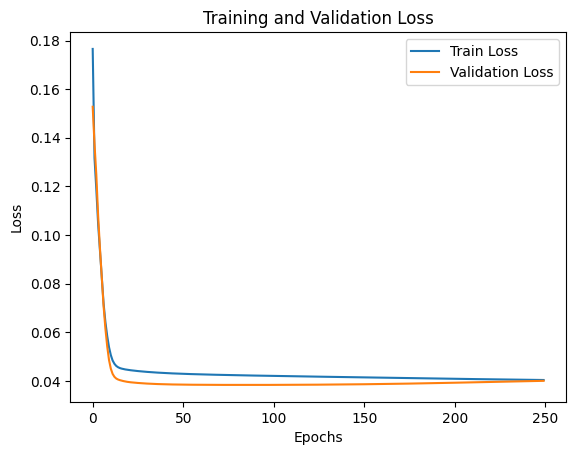

In [71]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 10.1312 , SI: 0.0699 
MAPE:  铁口1温度: 0.4556% , SI: 12.7717%
MRE :  铁口1温度: 0.0046  , SI: 0.1277 
per :  铁口1温度: 0.7500  , SI: 0.8917 


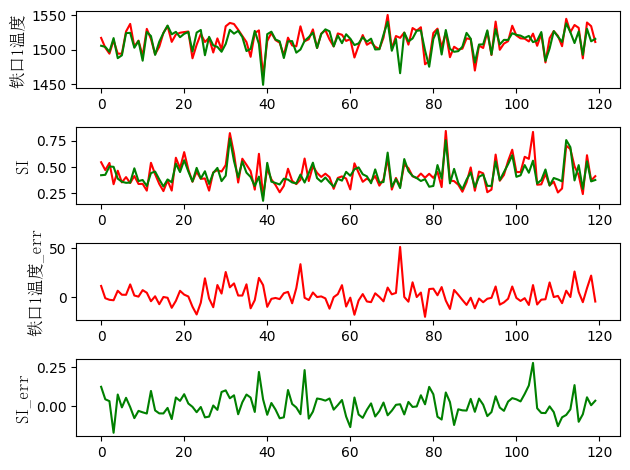

In [72]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test

# y_test = y_test[:-1]
# y_pred_0=y_pred_0[1:]
# y_pred_1=y_pred_1[1:]

double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


In [73]:
# 创建预测模型实例
features_size = 9
hidden_size_predict = 16
# 设置随机种子
torch.manual_seed(0)
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []


第 250/250 轮, 训练误差: 0.0524, 验证误差: 0.0551
epoch_sum: 0


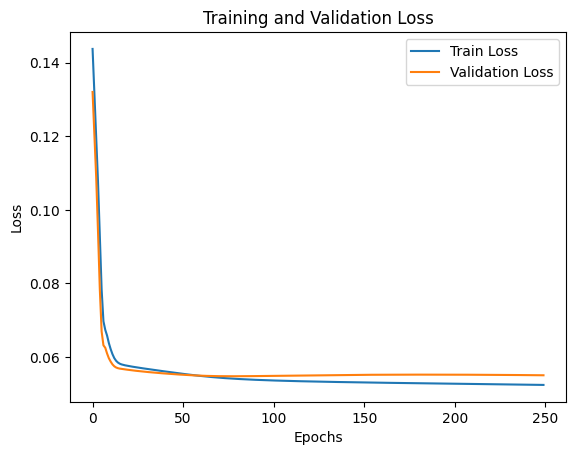

In [74]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 9.5948 , SI: 0.0788 
MAPE:  铁口1温度: 0.4876% , SI: 13.0443%
MRE :  铁口1温度: 0.0049  , SI: 0.1304 
per :  铁口1温度: 0.7395  , SI: 0.8235 


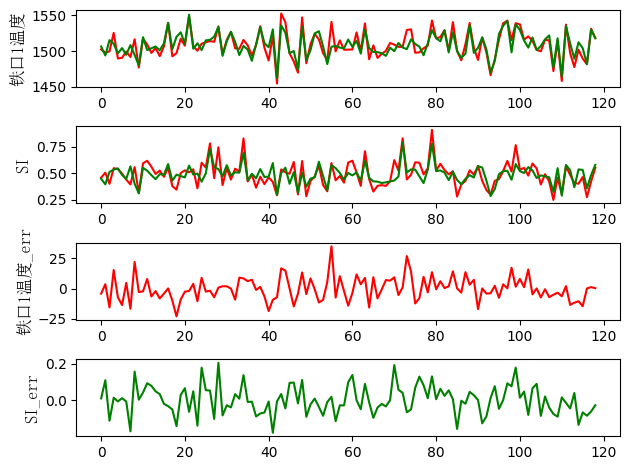

In [75]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test
double_control_predict_result(scalers,output_term,y_test,y_pred_0,y_pred_1)


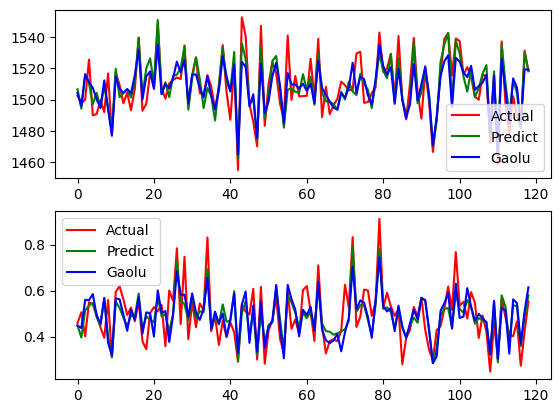

In [76]:
# 高炉、预测、原始对比
gaolu_predict_raw(scalers,output_term,model,model_gaolu,X_predict_test,y_predict_test)


In [77]:
# 自定义预测
numpy_predict = CustomPredictor_double(model,hidden_size_predict)


In [81]:
#生成控制时域的数据格式
def generate_k_data(time_steps,features):
    k_data = torch.randn(1, time_steps + 1, features).numpy().round(4)
    # k_data = np(k_data)
    print(k_data.shape)
    return k_data

ggg = generate_k_data(time_steps,features_size)
ggg



(1, 3, 9)


array([[[-0.1923,  0.7343, -0.633 , -0.038 , -1.1527,  2.1341,  1.1653,
         -0.2664,  0.4317],
        [ 0.4282,  0.7446,  0.8728,  0.7415,  1.2215, -1.2438,  1.0996,
          0.0186,  0.9571],
        [-0.7271,  1.1345,  1.6972,  0.0295, -0.2399,  0.2266,  0.4858,
         -0.2411, -2.6307]]], dtype=float32)

In [86]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    
    if isprint==1:
        print('kaishi --------------------------------------------------')
        print(k_data.round(4))
        print(k_data.shape)
        print(k_data[0,:,1])

    # 获取猜测值[U1, U2, U3, U4]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]

    if isprint==1:
        print( U1, U2, U3, U4, U5, U6, U7)

    
    u1   = np.concatenate((k_data[0,:,0],U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((k_data[0,:,1],U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((k_data[0,:,2],U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((k_data[0,:,3],U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((k_data[0,:,4],U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((k_data[0,:,5],U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((k_data[0,:,6],U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((k_data[0,:,7],np.ones(P)))
    y2   = np.concatenate((k_data[0,:,8],np.ones(P)))
    
    if isprint==1:
        print('新加入控制U与k_data拼接：')
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(y1.round(4))
        print(y2.round(4))

    #提取k时刻真实值
    y1_k = y1[time_steps]
    y2_k = y2[time_steps]
    if isprint==1:
        print('y1_k,y2_k',y1_k.round(4),y2_k.round(4)) 
        

    #使用过去数据对k时刻的y进行预测
    for j in range(1):
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j+2]*np.ones(time_steps),
                                y2[j+2]*np.ones(time_steps))
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_m_k,y2_m_k = numpy_predict.predict(x)
        
        if isprint==1:
            print('y1_m_k,y2_m_k',y1_m_k.round(4),y2_m_k.round(4))

    E1_k = y1_k - y1_m_k
    E2_k = y2_k - y2_m_k


    #对M控制时刻里面的进行预测
    for j in range(1,M+1):  
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j+2]*np.ones(time_steps),
                                y2[j+2]*np.ones(time_steps))
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_k_j,y2_k_j = numpy_predict.predict(x)
        
        if isprint==1:
            print('y1_k_j,y2_k_j',y1_k_j.round(4),y2_k_j.round(4))
        y1[j+time_steps] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+time_steps] = y2_k_j.item()
        if isprint==1:
            print('更新结构：')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(y1.round(4))
            print(y2.round(4))

    #对额外的P预测部份进行预测
    for j in range(M+1,P+1):
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j+2]*np.ones(time_steps),
                                y2[j+2]*np.ones(time_steps))
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_k_j,y2_k_j = numpy_predict.predict(x)
        if isprint==1:
            print('y1_k_j,y2_k_j',y1_k_j.round(4),y2_k_j.round(4))
        y1[j+time_steps] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+time_steps] = y2_k_j.item()

        if isprint==1:
            print('更新结构：')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(y1.round(4))
            print(y2.round(4))

    #获取下一次的k_data
    k_data2 = np.column_stack(( u1[1:time_steps+2],
                                u2[1:time_steps+2],
                                u3[1:time_steps+2],
                                u4[1:time_steps+2],
                                u5[1:time_steps+2],
                                u6[1:time_steps+2],
                                u7[1:time_steps+2],
                                y1[1:time_steps+2],
                                y2[1:time_steps+2])
                                )
    k_data2 = k_data2.reshape((1, k_data2.shape[0], k_data2.shape[1]))

    if isprint==1:
        
        print(k_data.round(4))
        print(f'下一时刻的k_data2')
        print(k_data2.round(4))
        print(k_data2.shape)

    #获取参考轨迹    # 一定要对照好做差的序列
    y1_r_aim  = generate_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 

    y2_r_aim  = generate_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[1+time_steps:]
    y2_M_k = y2[1+time_steps:]

    if isprint==1:
        print('y1_k',y1_k)  
        print('y1_m_k',y1_m_k)    
        print('y2_k',y2_k)  
        print('y2_m_k',y2_m_k)    

        print('第一个:')
        print('y1_aim  ',y1_aim)
        print('y1_r_aim',y1_r_aim)
        print('y1_r    ',y1_r)
        print('y1      ',y1)
        print('y1_M_k  ',y1_M_k)
        print('y1_M_k + h1 * E1_k',y1_M_k+h1*E1_k)
        print('h*E1_k',h1*E1_k)

        print('第二个:')
        print('y2_aim    ',y2_aim)
        print('y2_r_aim  ',y2_r_aim)
        print('y2_r      ',y2_r)
        print('y2        ',y2)
        print('y2_M_k    ',y2_M_k)
        print('y2_M_k+h2*E2_k',y2_M_k+h2*E2_k)
        print('h*E2_k    ',h2*E2_k)

        print('u:')
        print(u1[time_steps:])
        print(u2[time_steps:])
        print(u3[time_steps:])
        print(u4[time_steps:])


    # print(U1, U2, U3, U4)
    # print('第一个:')
    # print('y1_r    ',y1_r)
    # print('y1_M_k + h1 * E1_k',y1_M_k+h1*E1_k)
    # print('第二个:')
    # print('y2_r      ',y2_r)
    # print('y2_M_k+h2*E2_k',y2_M_k+h2*E2_k)

    # 计算mse
    y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    # y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    # y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    u1_power = lamda1*np.sum((np.fabs(np.diff(u1[time_steps:]))))
    u2_power = lamda2*np.sum((np.fabs(np.diff(u2[time_steps:]))))
    u3_power = lamda3*np.sum((np.fabs(np.diff(u3[time_steps:]))))
    u4_power = lamda4*np.sum((np.fabs(np.diff(u4[time_steps:]))))
    u5_power = lamda2*np.sum((np.fabs(np.diff(u5[time_steps:]))))
    u6_power = lamda3*np.sum((np.fabs(np.diff(u6[time_steps:]))))
    u7_power = lamda4*np.sum((np.fabs(np.diff(u7[time_steps:]))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))


    # print('单次寻优结束')
    return mse , k_data2, E1_k*h1, E2_k*h2


In [88]:
iscontrol = True
Times = 100


In [89]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = get_y_aim_data(scalers,output_term,Times)

# MPC参数
P = 3  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度

#生成控制时域的数据格式
k_data = generate_k_data(time_steps,features_size)


# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []


# MPC控制循环
for k in range(40):
    if iscontrol == False:
        break
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    # 设置退出条件
    exit_conditions = {'maxiter': 1000}  # 您可以根据需要调整容差

    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组
    
    optimized_U1, optimized_U2, \
        optimized_U3, optimized_U4, \
        optimized_U5, optimized_U6, \
        optimized_U7 = result.x[0:M], result.x[M:2*M], result.x[2*M:3*M], result.x[3*M:4*M], result.x[4*M:5*M], result.x[5*M:6*M], result.x[6*M:7*M]



    # 获取当前时刻下，在最优的U1、U2下的响应    
    U1 = optimized_U1
    U2 = optimized_U2
    U3 = optimized_U3
    U4 = optimized_U4
    U5 = optimized_U5
    U6 = optimized_U6
    U7 = optimized_U7
    u1   = np.concatenate((k_data[0,:,0],U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((k_data[0,:,1],U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((k_data[0,:,2],U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((k_data[0,:,3],U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((k_data[0,:,4],U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((k_data[0,:,5],U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((k_data[0,:,6],U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((k_data[0,:,7],np.zeros(P)))
    y2   = np.concatenate((k_data[0,:,8],np.zeros(P)))
    j=1 
    x = np.column_stack((   u1[j+1:j+time_steps+1],
                            u2[j+1:j+time_steps+1],
                            u3[j+1:j+time_steps+1],
                            u4[j+1:j+time_steps+1],
                            u5[j+1:j+time_steps+1],
                            u6[j+1:j+time_steps+1],
                            u7[j+1:j+time_steps+1],
                            y1[j+2]*np.ones(time_steps),
                            y2[j+2]*np.ones(time_steps))
                            )
    x = x.reshape((1, x.shape[0], x.shape[1]))

    y1_pred0, y2_pred0 = model.my_predict(x)
    y1_pred, y2_pred = model_gaolu.my_predict(x)
    



    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2,optimized_U3,optimized_U4,optimized_U5,optimized_U6,optimized_U4),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 
    
    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))

    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    all_pred_u5.append(U5[0])
    all_pred_u6.append(U6[0])
    all_pred_u7.append(U7[0])

    
    k_data2[0,:,7] = y1_pred
    k_data2[0,:,8] = y2_pred


    k_data = k_data2
    # print(f'下一时刻的k_data2')
    # print(k_data.round(4))
    # print(k_data.shape)
    # 进入下一时刻，更新预测时域、控制时域，即k_data



(1, 3, 9)
这是对第0时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [0.0985] 高炉 [-0.2395] 高炉与设定误差 [0.17] 模型误差 [0.338] 校正值 [-0.6648]
2设定 -0.2125 预测 [-0.1103] 高炉 [-0.1417] 高炉与设定误差 [-0.0707] 模型误差 [0.0314] 校正值 [0.4821]
这是对第1时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [-0.1262] 高炉 [-0.0239] 高炉与设定误差 [-0.0457] 模型误差 [-0.1023] 校正值 [-0.3621]
2设定 -0.2125 预测 [-0.2854] 高炉 [-0.0967] 高炉与设定误差 [-0.1158] 模型误差 [-0.1887] 校正值 [0.047]
这是对第2时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [-0.3677] 高炉 [-0.0311] 高炉与设定误差 [-0.0385] 模型误差 [-0.3365] 校正值 [0.0957]
2设定 -0.2125 预测 [-0.2758] 高炉 [-0.1449] 高炉与设定误差 [-0.0676] 模型误差 [-0.131] 校正值 [0.1576]
这是对第3时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [-0.4315] 高炉 [-0.0723] 高炉与设定误差 [0.0027] 模型误差 [-0.3591] 校正值 [0.308]
2设定 -0.2125 预测 [-0.2706] 高炉 [-0.1318] 高炉与设定误差 [-0.0807] 模型误差 [-0.1389] 校正值 [0.2212]
这是对第4时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [-0.4294] 高炉 [-0.067] 高炉与设定误差 [-0.0025] 模型误差 [-0.3624] 校正值 [0.426]
2设定 -0.2125 预测 [-0.2457] 高炉 [-0.0895] 高炉与设定误差 [-0.123] 模型误差 [-0.1562] 校正值 [0.2048]
这是对第5时刻的最优U1、U2输入求解
1设定 -0.0696 预测 [-0.4234] 高炉 [-0.0648] 高炉与设

In [90]:
if iscontrol == True:
    y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
    y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)).flatten()
    all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1).reshape(-1, 1)).flatten()
    all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2).reshape(-1, 1)).flatten()
    all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3).reshape(-1, 1)).flatten()
    all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4).reshape(-1, 1)).flatten()
    a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')


上线分别是：[2.00736825e+04 2.48731508e-04]、[3.37254652e+01 3.41094835e-06]、[ 4.32087465e-01 -2.78527280e-04]、[236.915       36.54472222]


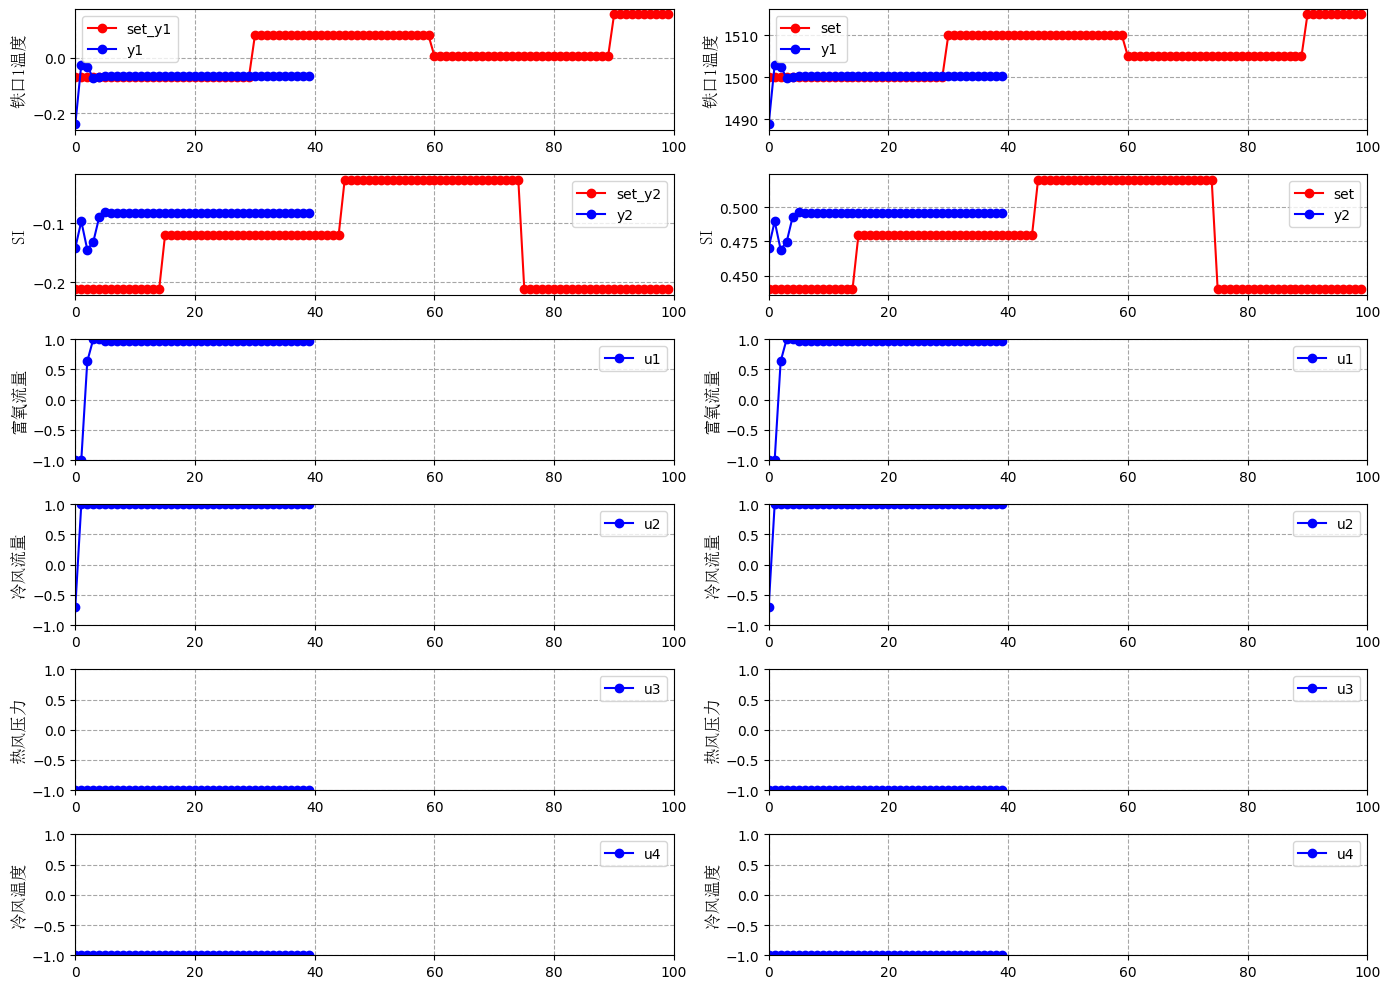

In [91]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
if iscontrol == True:
    plt.figure(figsize=(14, 10))
    
    # 第一个维度的曲线
    plt.subplot(6, 2, 1)
    plt.plot(set_y1_trans, 'ro-', label='set_y1')
    plt.plot(all_pred_y1, 'bo-', label='y1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的曲线
    plt.subplot(6, 2, 3)
    plt.plot(set_y2_trans, 'ro-', label='set_y2')
    plt.plot(all_pred_y2, 'bo-', label='y2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第一个维度的u1曲线
    plt.subplot(6, 2, 5)
    plt.plot(all_pred_u1, 'bo-', label='u1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的u2曲线
    plt.subplot(6, 2, 7)
    plt.plot(all_pred_u2, 'bo-', label='u2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第三个维度的u3曲线
    plt.subplot(6, 2, 9)
    plt.plot(all_pred_u3, 'bo-', label='u3')  # 修改标签为 'u3'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第四个维度的u4曲线
    plt.subplot(6, 2, 11)
    plt.plot(all_pred_u4, 'bo-', label='u4')  # 修改标签为 'u4'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')



    ######################################################

    # 第一个维度的曲线
    plt.subplot(6, 2, 2)
    plt.plot(set_y1, 'ro-', label='set')
    plt.plot(y1_pred_inverse_transform, 'bo-', label='y1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的曲线
    plt.subplot(6, 2, 4)
    plt.plot(set_y2, 'ro-', label='set')
    plt.plot(y2_pred_inverse_transform, 'bo-', label='y2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第一个维度的u1曲线
    plt.subplot(6, 2, 6)
    plt.plot(all_pred_u1, 'bo-', label='u1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的u2曲线
    plt.subplot(6, 2, 8)
    plt.plot(all_pred_u2, 'bo-', label='u2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第三个维度的u3曲线
    plt.subplot(6, 2, 10)
    plt.plot(all_pred_u3, 'bo-', label='u3')  # 修改标签为 'u3'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第四个维度的u4曲线
    plt.subplot(6, 2, 12)
    plt.plot(all_pred_u4, 'bo-', label='u4')  # 修改标签为 'u4'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')






    # 调整子图布局
    plt.tight_layout()
    plt.show()
